In [4]:
# @title STEP 1: MNIST DATASET LOADING AND PROCESSING
# @title ## Markdown
# @markdown Define client and Server Model (FFNN)

@markdown
# @markdown ---
#import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0



SyntaxError: invalid syntax (<ipython-input-4-c328b71107ff>, line 8)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━

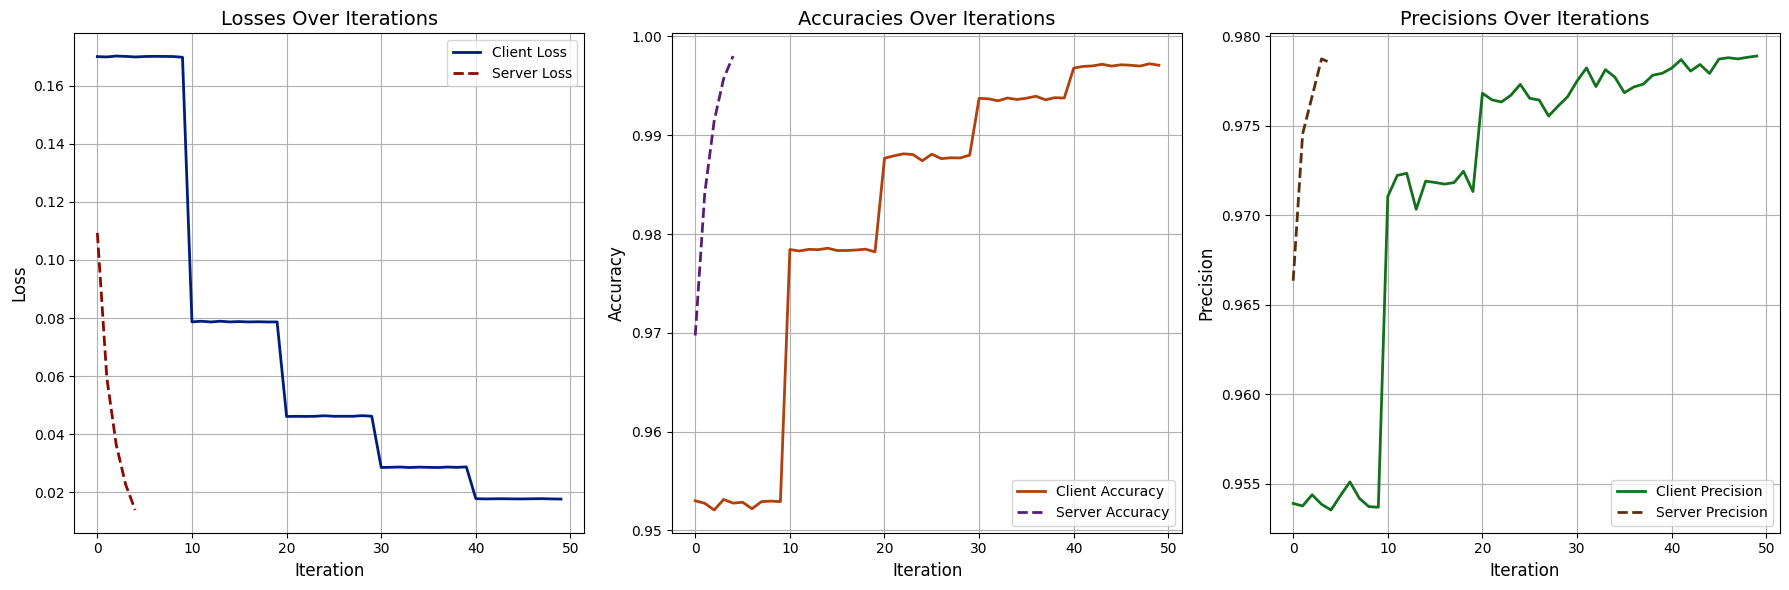

In [ ]:
# @title STEP 2: OUR DEFENSE ALGORITHM
#_______________________________________________________________________
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
# @title ## Markdown
# @markdown Hyperparameters for FFNN in Cosine Similarity-Based Federated Learning Defence Model .

# @markdown ---

Number_Of_Epoch=5 #@param {type:"integer"}
Batch_Size=32 #@param {type:"integer"}
Learning_Rate=0.0001 #@param {type:"number"}
# Initialize lists to store metrics for plotting
client_losses = []
client_accuracies = []
client_precisions = []
server_losses = []
server_accuracies = []
server_precisions = []

# Perform consensus algorithm to update server models
for iteration in range(5):  # Repeat the consensus algorithm for a desired number of iterations
    client_models_updated = []
    for client_model in client_models:
        similarities = []
        for server_model in server_models:
            # Normalize weights
            client_weights_normalized = [layer.flatten() / np.linalg.norm(layer.flatten()) for layer in client_model.get_weights()]
            server_weights_normalized = [layer.flatten() / np.linalg.norm(layer.flatten()) for layer in server_model.get_weights()]

            # Calculate cosine similarity between client and server model weights
            similarity = cosine_similarity([np.concatenate(client_weights_normalized)], [np.concatenate(server_weights_normalized)])[0][0]
            similarities.append(similarity)

        # Choose the server model with highest cosine similarity
        best_server_index = np.argmax(similarities)
        best_server_model = server_models[best_server_index]

        # Update client model with weights from the best server model
        client_model.set_weights(best_server_model.get_weights())

        # Create a new optimizer instance for the updated client model
        optimizer = Adam(learning_rate=Learning_Rate)
        client_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train client model with local data
        history = client_model.fit(X_train, y_train, epochs=Number_Of_Epoch, batch_size=Batch_Size, verbose=0)

        # Store loss, accuracy, and precision for client model
        client_losses.append(history.history['loss'][-1])
        client_accuracies.append(history.history['accuracy'][-1])
        y_pred = np.argmax(client_model.predict(X_test), axis=-1)
        client_precisions.append(precision_score(y_test, y_pred, average='weighted'))

        # Add updated client model to the list
        client_models_updated.append(client_model)

    server_models_updated = []
    for server_model in server_models:
        similarities = []
        for client_model in client_models_updated:
            # Normalize weights
            server_weights_normalized = [layer.flatten() / np.linalg.norm(layer.flatten()) for layer in server_model.get_weights()]
            client_weights_normalized = [layer.flatten() / np.linalg.norm(layer.flatten()) for layer in client_model.get_weights()]

            # Calculate cosine similarity between server and client model weights
            similarity = cosine_similarity([np.concatenate(server_weights_normalized)], [np.concatenate(client_weights_normalized)])[0][0]
            similarities.append(similarity)

        # Choose the client model with highest cosine similarity
        best_client_index = np.argmax(similarities)
        best_client_model = client_models_updated[best_client_index]

        # Update server model with weights from the best client model
        server_model.set_weights(best_client_model.get_weights())

        # Create a new optimizer instance for the updated server model
        optimizer = Adam(learning_rate=Learning_Rate)
        server_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train server model with local data
        history = server_model.fit(X_train, y_train, epochs=Number_Of_Epoch, batch_size=Batch_Size, verbose=0)

# Store loss, accuracy, and precision for server model
        server_losses.append(history.history['loss'][-1])
        server_accuracies.append(history.history['accuracy'][-1])
        y_pred = np.argmax(server_model.predict(X_test), axis=-1)
        server_precisions.append(precision_score(y_test, y_pred, average='weighted'))

        # Add updated server model to the list
        server_models_updated.append(server_model)

        # Plot losses, accuracies, and precisions

# Set up a sophisticated color palette
palette = sns.color_palette("dark", 6)  # Dark sophisticated colors
client_loss_color = palette[0]           # Dark blue
client_accuracy_color = palette[1]       # Dark green
client_precision_color = palette[2]      # Dark purple
server_loss_color = palette[3]           # Dark red
server_accuracy_color = palette[4]       # Dark orange
server_precision_color = palette[5]      # Dark teal

# Plot losses, accuracies, and precisions with sophisticated color scheme
plt.figure(figsize=(18, 6))

# Plot Losses
plt.subplot(1, 3, 1)
plt.plot(client_losses, label='Client Loss', color=client_loss_color, linewidth=2)
plt.plot(server_losses, label='Server Loss', color=server_loss_color, linestyle='--', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Losses Over Iterations', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)

# Plot Accuracies
plt.subplot(1, 3, 2)
plt.plot(client_accuracies, label='Client Accuracy', color=client_accuracy_color, linewidth=2)
plt.plot(server_accuracies, label='Server Accuracy', color=server_accuracy_color, linestyle='--', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracies Over Iterations', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)

# Plot Precisions
plt.subplot(1, 3, 3)
plt.plot(client_precisions, label='Client Precision', color=client_precision_color, linewidth=2)
plt.plot(server_precisions, label='Server Precision', color=server_precision_color, linestyle='--', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precisions Over Iterations', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()